Histogram of Oriented Gradients (HOG)
===
  - Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
  - Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 

Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

From the rubric, document:

  1. Explain how (and identify where in your code) you extracted HOG features from the training images. Explain how you settled on your final choice of HOG parameters.
    - Explanation given for methods used to extract HOG features, including which color space was chosen, which HOG parameters (orientations, pixels_per_cell, cells_per_block), and why. 
  2. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).
    - The HOG features extracted from the training data have been used to train a classifier, could be SVM, Decision Tree or other. Features should be scaled to zero mean and unit variance before training the classifier.

In [193]:
import numpy as np
import glob
import cv2
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline

In [156]:
# Perform a histogram of oriented gradients (HOG) feature extraction on a labeled training set of images

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    return hog(img, orientations=orient, 
          pixels_per_cell=(pix_per_cell, pix_per_cell),
          cells_per_block=(cell_per_block, cell_per_block), 
          transform_sqrt=False, 
          visualise=vis, feature_vector=feature_vec)

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = np.array([])
            for channel in range(feature_image.shape[2]):
                np.append(hog_features, get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        features.append(single_img_features(img=image, color_space=color_space, spatial_size=spatial_size,
                                           hist_bins=hist_bins, orient=orient,
                                           pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                           hog_channel=hog_channel,
                                           spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat))
    # Return list of feature vectors
    return features


In [183]:
# Load training data

car_image_list = glob.glob('./data/vehicles/**/*.png')
non_car_image_list = glob.glob('./data/non-vehicles/**/*.png')

color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(car_image_list, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(non_car_image_list, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_image_list)), np.zeros(len(non_car_image_list))))


In [184]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

# Train a linear SVM classifier
svc = LinearSVC()
svc.fit(X_train, y_train)

fit_accuracy = svc.score(X_test, y_test)
print("Accuracy:", fit_accuracy)


Accuracy: 0.897522522523


Sliding Window Search
===

  - Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

From the rubric, document:

  1. Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?
    - A sliding window approach has been implemented, where overlapping tiles in each test image are classified as vehicle or non-vehicle. Some justification has been given for the particular implementation chosen.
  2. Show some examples of test images to demonstrate how your pipeline is working. How did you optimize the performance of your classifier?
    - Some discussion is given around how you improved the reliability of the classifier i.e., fewer false positives and more reliable car detections (this could be things like choice of feature vector, thresholding the decision function, hard negative mining etc.)


In [164]:
# Implement a sliding-window technique and use your trained classifier to search for vehicles in images
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = math.ceil((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = math.ceil((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


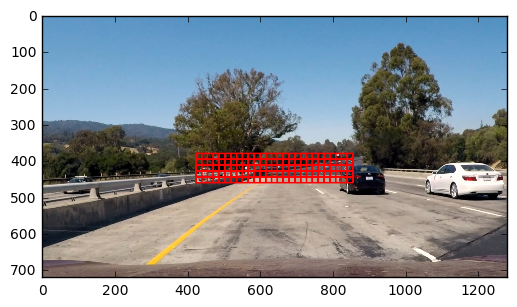

In [185]:
image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)
image = image.astype(np.float32)/255.

sliding_windows_parameter_set=[]

# Determine the scale and windows to use
# 1. Small window

xy_window=(32, 32)
x_start_stop = [np.int(draw_image.shape[1]*0.33), np.int(draw_image.shape[1]*0.66)]
y_start_stop = [380, 450]

sliding_windows_parameter_set.append([xy_window,x_start_stop,y_start_stop])

windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=xy_window, xy_overlap=(0.5, 0.5))                      

window_img = draw_boxes(draw_image, windows, color=(255, 0, 0), thick=3)

plt.imshow(window_img)

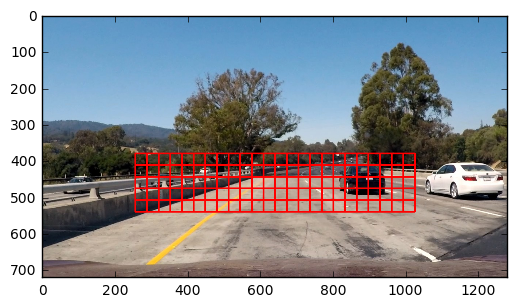

In [186]:
# 2. Medium small window

xy_window=(64, 64)
x_start_stop = [np.int(draw_image.shape[1]*0.1*2), np.int(draw_image.shape[1]*0.1*8)]
y_start_stop = [380, 520]

sliding_windows_parameter_set.append([xy_window,x_start_stop,y_start_stop])

windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=xy_window, xy_overlap=(0.5, 0.5))                      

window_img = draw_boxes(draw_image, windows, color=(255, 0, 0), thick=3)

plt.imshow(window_img)

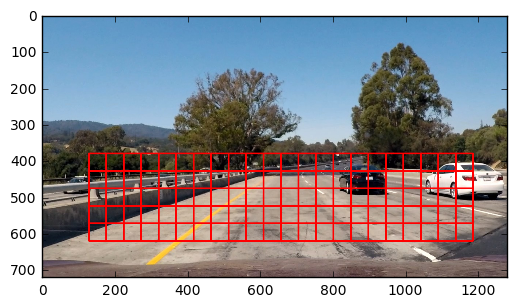

In [187]:
# 3. Medium large window

xy_window=(96, 96)
x_start_stop = [np.int(draw_image.shape[1]*0.1), np.int(draw_image.shape[1]*0.1*9)]
y_start_stop = [380, 600]

sliding_windows_parameter_set.append([xy_window,x_start_stop,y_start_stop])

windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=xy_window, xy_overlap=(0.5, 0.5))                      

window_img = draw_boxes(draw_image, windows, color=(255, 0, 0), thick=3)

plt.imshow(window_img)

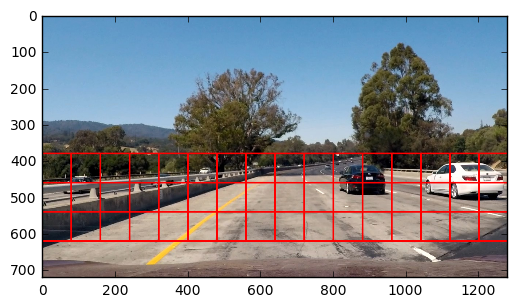

In [188]:
# 4. Large window

xy_window=(160, 160)
x_start_stop = [None, None]
y_start_stop = [380, 600]

sliding_windows_parameter_set.append([xy_window,x_start_stop,y_start_stop])

windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=xy_window, xy_overlap=(0.5, 0.5))                      

window_img = draw_boxes(draw_image, windows, color=(255, 0, 0), thick=3)

plt.imshow(window_img)

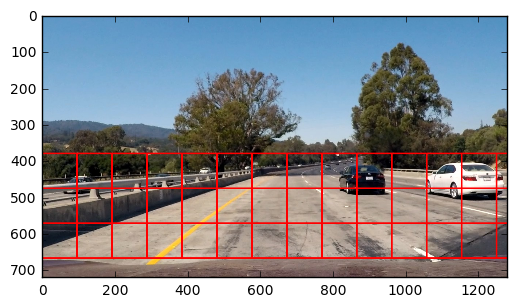

In [189]:
# 5. Extra large window

xy_window=(192,192)
x_start_stop = [None, None]
y_start_stop = [380, 600]

sliding_windows_parameter_set.append([xy_window,x_start_stop,y_start_stop])

windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=xy_window, xy_overlap=(0.5, 0.5))                      

window_img = draw_boxes(draw_image, windows, color=(255, 0, 0), thick=3)

plt.imshow(window_img)

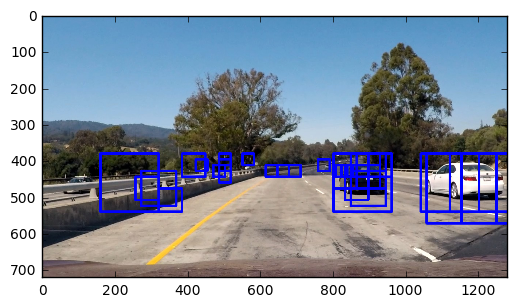

In [202]:

window_img = np.copy(draw_image)

hot_window_list = []

for window_parameter_set in sliding_windows_parameter_set:
    i_xy_window = window_parameter_set[0]
    i_x_start_stop = window_parameter_set[1]
    i_y_start_stop = window_parameter_set[2]
    windows = slide_window(image, x_start_stop=i_x_start_stop, y_start_stop=i_y_start_stop,
                    xy_window=i_xy_window, xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
    hot_window_list.append(hot_windows)

    window_img = draw_boxes(window_img, hot_windows, color=(0, 0, 255), thick=6)

plt.imshow(window_img)

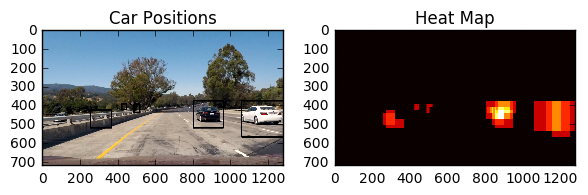

In [210]:

heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat, np.concatenate(hot_window_list))
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


Video Implementation
===
  - Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
  - Estimate a bounding box for vehicles detected.

From the rubric, document:
  1. Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
    - The sliding-window search plus classifier has been used to search for and identify vehicles in the videos provided. Video output has been generated with detected vehicle positions drawn (bounding boxes, circles, cubes, etc.) on each frame of video.
  2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.
    - A method, such as requiring that a detection be found at or near the same position in several subsequent frames, (could be a heat map showing the location of repeat detections) is implemented as a means of rejecting false positives, and this demonstrably reduces the number of false positives. Same or similar method used to draw bounding boxes (or circles, cubes, etc.) around high-confidence detections where multiple overlapping detections occur.
